# Random Erasing Data Augmentation

From the abstract of the [paper](https://arxiv.org/abs/1708.04896):

```
In training, Random Erasing randomly selects a rectangle region in an image and erases its pixels with random values. In this process, training images with various levels of occlusion are generated, which reduces the risk of over-fitting and makes the model robust to occlusion. Random Erasing is parameter learning free, easy to implement, and can be integrated with most of the CNN-based recognition models.
```

<img alt="Random Erase" src="images/random_erase.png" width="500" class="center">

As seen from image above, this `RandomErase` data augmentation, randomly selects a region from the input image, erases the existing image in that region and fills the region with random values.


## Training models with `RandomErase` using `timm`'s training script

To train a model using the `RandomErase` data augmentation using `timm`'s training script, simply add the `--reprob` flag with a probability value. 

```python
python train.py ../imagenette2-320 --reprob 0.4
```

Running the above command applies the `RandomErase` data augmentation to the input images with a probability of `0.4`.

## Using `RandomErase` data augmentation in custom training scripts

Section `1.1` provides an example of using `RandomErase` data augmentation to train a nueral net using `timm`'s training script.  But often you might want to simply just use `RandomErase` augmentation using your own custom training loop. This section explains how one could achieve that. 

The `RandomErase` data augmentation inside `timm` is implemented inside `RandomErasing` class. All we do in the code below, is first create an input image tensor, and visualize it. 

> NOTE: This variant of RandomErasing is intended to be applied to either a batch or single image tensor after it has been normalized by dataset mean and std. This is different from `RandAugment` where the class expects a `PIL.Image` as input. 

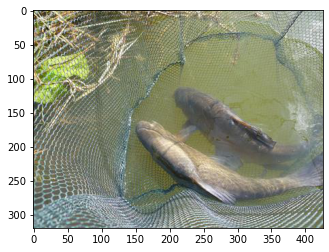

In [18]:
from PIL import Image
from timm.data.random_erasing import RandomErasing
from torchvision import transforms
from matplotlib import pyplot as plt

img = Image.open("../../imagenette2-320/train/n01440764/ILSVRC2012_val_00000293.JPEG")
x   = transforms.ToTensor()(img)
plt.imshow(x.permute(1, 2, 0))

Great, as we can see it is the same image of a "tench" as shown pretty much everywhere inside this documentation. Let's now apply the `RandomErasing` augmentation and visualize the results. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


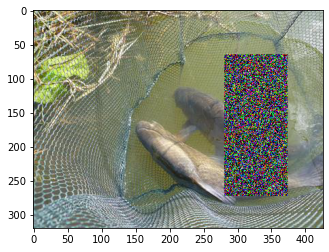

In [19]:
random_erase = RandomErasing(probability=1, mode='pixel', device='cpu')
plt.imshow(random_erase(x).permute(1, 2, 0))

As we can see, after applying the `RandomErasing` data augmentation, a square of random size inside the image has been replaced with random values as mentioned in the paper. Thus, pseudo-code to use `RandomErasing` in your custom training script would look something like: 

```python 
from timm.data.random_erasing import RandomErasing

# get input images and convert to `torch.tensor`
X, y = input_training_batch()
X = convert_to_torch_tensor(X)

# perform RandomErase data augmentation
random_erase = RandomErasing(probability=0.5)

# get augmented batch
X_aug = random_erase(X)

# do something here 
```

## `timm`'s implementation of `RandomErase`

In this section we will look at the source code of the `RandomErasing` class inside `timm`. The complete source code of this class looks like: 

```python
class RandomErasing:
    """ Randomly selects a rectangle region in an image and erases its pixels.
        'Random Erasing Data Augmentation' by Zhong et al.
        See https://arxiv.org/pdf/1708.04896.pdf

        This variant of RandomErasing is intended to be applied to either a batch
        or single image tensor after it has been normalized by dataset mean and std.
    Args:
         probability: Probability that the Random Erasing operation will be performed.
         min_area: Minimum percentage of erased area wrt input image area.
         max_area: Maximum percentage of erased area wrt input image area.
         min_aspect: Minimum aspect ratio of erased area.
         mode: pixel color mode, one of 'const', 'rand', or 'pixel'
            'const' - erase block is constant color of 0 for all channels
            'rand'  - erase block is same per-channel random (normal) color
            'pixel' - erase block is per-pixel random (normal) color
        max_count: maximum number of erasing blocks per image, area per box is scaled by count.
            per-image count is randomly chosen between 1 and this value.
    """

    def __init__(
            self,
            probability=0.5, min_area=0.02, max_area=1/3, min_aspect=0.3, max_aspect=None,
            mode='const', min_count=1, max_count=None, num_splits=0, device='cuda'):
        self.probability = probability
        self.min_area = min_area
        self.max_area = max_area
        max_aspect = max_aspect or 1 / min_aspect
        self.log_aspect_ratio = (math.log(min_aspect), math.log(max_aspect))
        self.min_count = min_count
        self.max_count = max_count or min_count
        self.num_splits = num_splits
        mode = mode.lower()
        self.rand_color = False
        self.per_pixel = False
        if mode == 'rand':
            self.rand_color = True  # per block random normal
        elif mode == 'pixel':
            self.per_pixel = True  # per pixel random normal
        else:
            assert not mode or mode == 'const'
        self.device = device

    def _erase(self, img, chan, img_h, img_w, dtype):
        if random.random() > self.probability:
            return
        area = img_h * img_w
        count = self.min_count if self.min_count == self.max_count else \
            random.randint(self.min_count, self.max_count)
        for _ in range(count):
            for attempt in range(10):
                target_area = random.uniform(self.min_area, self.max_area) * area / count
                aspect_ratio = math.exp(random.uniform(*self.log_aspect_ratio))
                h = int(round(math.sqrt(target_area * aspect_ratio)))
                w = int(round(math.sqrt(target_area / aspect_ratio)))
                if w < img_w and h < img_h:
                    top = random.randint(0, img_h - h)
                    left = random.randint(0, img_w - w)
                    img[:, top:top + h, left:left + w] = _get_pixels(
                        self.per_pixel, self.rand_color, (chan, h, w),
                        dtype=dtype, device=self.device)
                    break

    def __call__(self, input):
        if len(input.size()) == 3:
            self._erase(input, *input.size(), input.dtype)
        else:
            batch_size, chan, img_h, img_w = input.size()
            # skip first slice of batch if num_splits is set (for clean portion of samples)
            batch_start = batch_size // self.num_splits if self.num_splits > 1 else 0
            for i in range(batch_start, batch_size):
                self._erase(input[i], chan, img_h, img_w, input.dtype)
        return input
```

All the fun is going inside the `_erase` method which we will look into next. But in simple words what the above code is doing is that we call this class either passing in a single tensor of size 3 `CHW` or an input batch of size 4 `NCHW`. If it's an input batch, and batch is not split similar to `Augmix`, then we apply the `RandomErase` data augmentation to the whole batch otherwise we leave the first split as is which becomes the clean split. This splitting of the dataset has already been explained [here](https://fastai.github.io/timmdocs/dataset#AugmixDataset) and [here](https://fastai.github.io/timmdocs/tutorial_splitbn).

Let's now look at the `_erase` method in detail and understand all the magic. 

```python
    def _erase(self, img, chan, img_h, img_w, dtype):
        if random.random() > self.probability:
            return
        area = img_h * img_w
        count = self.min_count if self.min_count == self.max_count else \
            random.randint(self.min_count, self.max_count)
        for _ in range(count):
            for attempt in range(10):
                target_area = random.uniform(self.min_area, self.max_area) * area / count
                aspect_ratio = math.exp(random.uniform(*self.log_aspect_ratio))
                h = int(round(math.sqrt(target_area * aspect_ratio)))
                w = int(round(math.sqrt(target_area / aspect_ratio)))
                if w < img_w and h < img_h:
                    top = random.randint(0, img_h - h)
                    left = random.randint(0, img_w - w)
                    img[:, top:top + h, left:left + w] = _get_pixels(
                        self.per_pixel, self.rand_color, (chan, h, w),
                        dtype=dtype, device=self.device)
                    break
```

The `_erase` method above accepts an input `img` (torch.tensor), `chan` which represents the number of channels in the image and also `img_h` and `img_w` which refer to image height and width. 

We select a value for `count` based on `self.min_count` and `self.max_count`. The `self.min_count` has already been set to minimum number of random erase blocks, and `self.max_count` refers to the maximum number of random erase blocks. Most of the times, both default to 1, that is we only add a single random erase block to the input `img`. 

Next, we select a random `target_area` and `aspect_ratio` of the random erase block, and based on these we select the values of the `h` height and `w` width of the random erase block. 

Finally, we replace the pixels inside the image from location `img[:, top:top + h, left:left + w]` where `top` represents a random integer value on the y-axis and `left` represents a random integer value on the x-axis. The `_get_pixels` is a function implemented in `timm` that returns the random values to be filled inside the random erase block depending on the `Random Erase` mode inside `timm`. 

If `mode=='pixel'`, then, the `_get_pixels` returns a normal distribution, otherwise a constant value of `0` is filled. 